# Vehicle Detection
### Udacity Self Driving Car Engineer Nanodegree

In [1]:
import cv2
import numpy as np
from skimage.feature import hog
from skimage.io import imread
import matplotlib.image as mpimg
import glob
import csv
import pandas as pd
from random import randint
from scipy.misc import imresize
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import time
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline
print('Modules loaded')

Modules loaded


## Step 1: Data Exploration

### Check size and shape of our datasets

In [2]:
# Load car and non-car image sets
car_imgs = glob.glob('vehicles/*/*.png')
noncar_imgs = glob.glob('non-vehicles/*/*.png')

In [3]:
# check weather image shape is consistent 

print ("check  images for consistent shape")

shape_outliers = []
def check_shape(fn_list):
    for fn in fn_list:
        image =  imread(fn)
        if image.shape != (64, 64, 3):
            shape_outliers.append(fn)

check_shape(car_imgs)
check_shape(noncar_imgs)

print ('{} images have an unexpected shape'.format(len(shape_outliers)))

check  images for consistent shape
0 images have an unexpected shape


In [4]:
car_num = len(car_imgs)
noncar_num = len(noncar_imgs)
img_shape = (64, 64, 3)

print('car dataset_size: {}'.format(car_num))
print('noncar dataset_size: {}'.format(noncar_num))
print ('Image shape: {}'.format(img_shape))

car dataset_size: 8792
noncar dataset_size: 8968
Image shape: (64, 64, 3)


#### Result
We are good to go both the car and the noncar dataset have roughly the same size and all images have the same size

# Step 2: Feature Extraction

In [5]:
# Function to extract hog features
def get_hog_features(img, cspace='RGB', orient=9, pix_per_block=(16, 16), stride=(8, 8), pix_per_cell=(8, 8)):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'Lab':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    img_dim = img.shape[:2]
    hog = cv2.HOGDescriptor(img_dim, pix_per_block,
                            stride, pix_per_cell, orient)

    return np.ravel(hog.compute(feature_image))


# Function to compute color histogram features
def color_hist(img, cspace='RGB', nbins=32, bins_range=(0, 256)):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'Lab':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate(
        (channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Function to compute binned color features  
def bin_spatial(img, cspace='RGB', size=(32, 32)):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'Lab':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


# Function to extract hog features from a list of images
def extract_features(imgs, cspace='RGB', orient=9,
                     pix_per_block=(16, 16), stride=(8, 8), pix_per_cell=(8, 8), feat_type='hog features', hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = imread(file)

        hog_features = get_hog_features(image, cspace=cspace, orient=orient,
                                        pix_per_block=pix_per_block, stride=stride, pix_per_cell=pix_per_cell)
        if feat_type == 'hog + color histograms':
            hist_features = color_hist(image, cspace=cspace, nbins=hist_bins, bins_range=hist_range)
            features.append(np.concatenate((hog_features, hist_features)))
        elif feat_type == 'hog + binned color':
            spatial_features = bin_spatial(image, cspace=cspace, size=(32, 32))
            features.append(np.concatenate((hog_features, spatial_features)))
        
        elif feat_type == 'hog + color histograms + binned color':
            hist_features = color_hist(image, cspace=cspace, nbins=hist_bins, bins_range=hist_range)
            spatial_features = bin_spatial(image, cspace=cspace, size=(32, 32))
            features.append(np.concatenate((hog_features, hist_features, spatial_features)))
        
        else:
            # Append the new feature vector to the features list
            features.append(hog_features)

    # Return list of feature vectors
    return features


# Step 3a: Experiment with different Classifiers and Feature Sets

Test these Classifiers :
* Linear Support Vector Classifier
* Logistic Regression Classifier
* Multi-layer Perceptron

Test each classifier with 4 different feature sets:
* Set 1: hog features 
* Set 2: hog features + color histograms
* Set 3: hog features + binned color features 
* Set 4: hog features + color histograms + binned color features 

I always use hog features as a base. Then I add different combinations of color histograms and binned color features 


In [6]:
# set type of feature; choose from 4 predefined feature sets
feature_type = 'hog + color histograms'

In [7]:
# Build the datasets
car_features = extract_features(car_imgs, cspace='YUV', orient=9,
                                pix_per_block=(16, 16), stride=(8, 8), pix_per_cell=(8, 8), feat_type=feature_type, hist_bins=32, hist_range=(0, 256))

noncar_features = extract_features(noncar_imgs, cspace='YUV', orient=9,
                                   pix_per_block=(16, 16), stride=(8, 8), pix_per_cell=(8, 8), feat_type=feature_type, hist_bins=32, hist_range=(0, 256))
print('done')


done


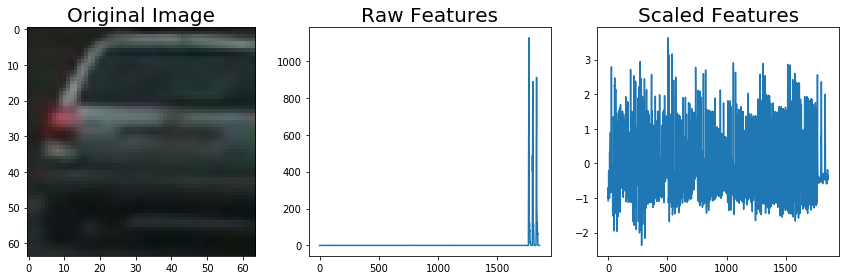

In [8]:
# Create an array stack of feature vectors
X = np.vstack((car_features, noncar_features)).astype(np.float64)
# Fit a per-column scaler
scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = scaler.transform(X)
ind = np.random.randint(0, len(car_imgs)) 
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.imshow(mpimg.imread(car_imgs[ind]))
ax1.set_title('Original Image', fontsize=20)
ax2.plot(X[ind])
ax2.set_title('Raw Features', fontsize=20)
ax3.plot(scaled_X[ind])
ax3.set_title('Scaled Features', fontsize=20)
f.tight_layout()



In [9]:
# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(noncar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

In [10]:
def reset_stats():
    with open('stats.csv', 'w', newline='') as fp:
         a = csv.writer(fp, delimiter=',')
         data = [['feat', 'clf', 'test_acc', 'train_acc', 'train_time', 'pred_time', 'vec_length']]       
         a.writerows(data)


def log_results(feat, clf, test_acc, train_acc, train_time, pred_time, vec_length, save_to_csv=False):
    
    print('Feature vector length for {} :'.format(feat), vec_length)
    print(train_time, 'Seconds to train {}'.format(clf))
    print('Train Accuracy of {} = '.format(clf), train_acc)
    print('Test Accuracy of {} = '.format(clf), test_acc)
    print(pred_time, 'Seconds to predict', n_predict,'labels with {}'.format(clf))
    
    if save_to_csv:
        with open('stats.csv', 'a', newline='') as fp:
            a = csv.writer(fp, delimiter=',')
            data = [[feat, clf, test_acc, train_acc, train_time, pred_time, vec_length]]       
            a.writerows(data)
            
# reset_stats()

### Linear Support Vector Classifier

In [11]:
from sklearn.svm import LinearSVC

vec_length = len(X_train[0])
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
train_time = round(t2-t, 2)
# Check the score of the SVC
train_acc = round(svc.score(X_train, y_train), 4)
test_acc = round(svc.score(X_test, y_test), 4)
# Check the prediction time for 100 samples
t=time.time()
n_predict = 100
predictions =  svc.predict(X_test[0:n_predict])
t2 = time.time()
pred_time = round(t2-t, 5)


# save results in stats.csv
log_results(feature_type,'svc', test_acc, train_acc, train_time, pred_time, vec_length, save_to_csv=True)

Feature vector length for hog + color histograms : 1860
5.27 Seconds to train svc
Train Accuracy of svc =  1.0
Test Accuracy of svc =  0.9735
0.00032 Seconds to predict 100 labels with svc


### Logistic Regression  Classifier

In [12]:
from sklearn.linear_model import LogisticRegression

vec_length = len(X_train[0])
# Use a linear lrc 
lrc = LogisticRegression(max_iter=10)
# Check the training time for the lrc
t=time.time()
lrc.fit(X_train, y_train)
t2 = time.time()
train_time = round(t2-t, 2)
# Check the score of the lrc
train_acc = round(lrc.score(X_train, y_train), 4)
test_acc = round(lrc.score(X_test, y_test), 4)
# Check the prediction time for 100 samples
t=time.time()
n_predict = 100
predictions =  svc.predict(X_test[0:n_predict])
t2 = time.time()
pred_time = round(t2-t, 5)


# save results in stats.csv
log_results(feature_type,'lrc', test_acc, train_acc, train_time, pred_time, vec_length, save_to_csv=True)

Feature vector length for hog + color histograms : 1860
11.53 Seconds to train lrc
Train Accuracy of lrc =  1.0
Test Accuracy of lrc =  0.9747
0.00031 Seconds to predict 100 labels with lrc


### Multi-layer Perceptron

In [13]:
vec_length = len(X_train[0])
# Use a linear mlp 
mlp = MLPClassifier()
# Check the training time for the mlp
t=time.time()
mlp.fit(X_train, y_train)
t2 = time.time()
train_time = round(t2-t, 2)
# Check the score of the mlp
train_acc = round(mlp.score(X_train, y_train), 4)
test_acc = round(mlp.score(X_test, y_test), 4)
# Check the prediction time for 100 samples
t=time.time()
n_predict = 100
predictions =  mlp.predict(X_test[0:n_predict])
t2 = time.time()
pred_time = round(t2-t, 5)


# save results in stats.csv
log_results(feature_type, 'mlp', test_acc, train_acc, train_time, pred_time, vec_length, save_to_csv=True)

Feature vector length for hog + color histograms : 1860
7.0 Seconds to train mlp
Train Accuracy of mlp =  1.0
Test Accuracy of mlp =  0.9932
0.00119 Seconds to predict 100 labels with mlp


# Step 3b: Compare Results and Conclusion

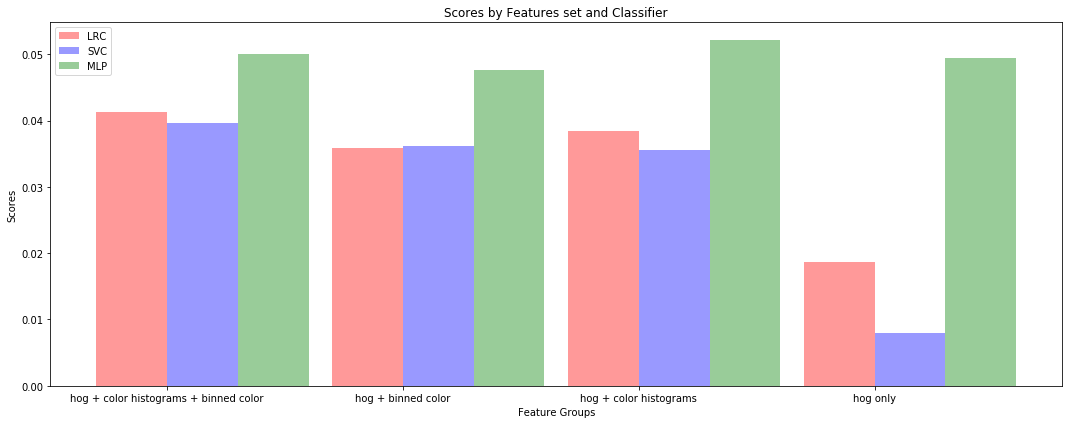

                                     feat  clf  test_acc  train_acc  \
0   hog + color histograms + binned color  svc    0.9823     1.0000   
1   hog + color histograms + binned color  lrc    0.9840     1.0000   
2   hog + color histograms + binned color  mlp    0.9927     1.0000   
3                      hog + binned color  svc    0.9789     1.0000   
4                      hog + binned color  lrc    0.9786     1.0000   
5                      hog + binned color  mlp    0.9904     1.0000   
6                  hog + color histograms  svc    0.9783     1.0000   
7                  hog + color histograms  lrc    0.9811     1.0000   
8                  hog + color histograms  mlp    0.9949     1.0000   
9                                hog only  svc    0.9507     1.0000   
10                               hog only  lrc    0.9614     0.9977   
11                               hog only  mlp    0.9921     1.0000   

    train_time  pred_time  vec_length  
0        14.12    0.00055        493

In [15]:
df_all = pd.read_csv('stats.csv')
df_acc = df_all[['feat', 'clf', 'test_acc']]

n_groups = 4
# get value close to min test acc to scale data for better visualisation 
vis_bias = df_acc['test_acc'].min() - 0.008

acc_lrc = df_acc[df_acc['clf']=='lrc']['test_acc'].values - vis_bias
acc_svc = df_acc[df_acc['clf']=='svc']['test_acc'].values - vis_bias 
acc_mlp = df_acc[df_acc['clf']=='mlp']['test_acc'].values - vis_bias

fig, ax = plt.subplots(figsize=(15, 6))

index = np.arange(n_groups)
bar_width = 0.30

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(index, acc_lrc, bar_width,
                 alpha=opacity,
                 color='r',
                 error_kw=error_config,
                 label='LRC')

rects2 = plt.bar(index + bar_width, acc_svc, bar_width,
                 alpha=opacity,
                 color='b',
                 error_kw=error_config,
                 label='SVC')

rects3 = plt.bar(index + bar_width*2, acc_mlp, bar_width,
                 alpha=opacity,
                 color='g',
                 error_kw=error_config,
                 label='MLP')

plt.xlabel('Feature Groups')
plt.ylabel('Scores')
plt.title('Scores by Features set and Classifier')
plt.xticks(index + bar_width / 2, ('hog + color histograms + binned color', 'hog + binned color', 'hog + color histograms', 'hog only'))
plt.legend()

plt.tight_layout()
plt.show()

print(df_all)

# Step 4: Vehicle Detection
###  Implement Sliding-window Technique and try on test images

In [16]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img


def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.75, 0.75)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) 
    ny_windows = np.int(yspan/ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = (xs+1)*nx_pix_per_step + x_start_stop[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = (ys+1)*ny_pix_per_step + y_start_stop[0]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


In [41]:
window_sizes = range(320,720,16)
def pipeline(image, clf='MLP', vis=False, feat_type='hog + color histograms'):
    on_windows = []
    
    # implement Multi-scale Windows; increase window size 16px from 320px to 720px
    for size in window_sizes:
        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 660], 
                            xy_window=(size, size), xy_overlap=(0.75, 0.75))  
        
        for window in windows:
            # Extract the test window from original image
            current = cv2.resize((image[window[0][1]: window[1][1], window[0][0]: window[1][0]]),(64,64))
            
            #convert to YUV color space
            feature_image = cv2.cvtColor(current, cv2.COLOR_RGB2YUV)
            
            # Extract hog features for that window 
            img_dim = feature_image.shape[:2]
            hog = cv2.HOGDescriptor(img_dim, (16, 16),
                            (8, 8), (8, 8), 9)
            hog_features = np.ravel(hog.compute(feature_image))
            
            
            if feat_type == 'hog + color histograms':
                # Extract color features features for that window 
                # Compute the histogram of the color channels separately
                nbins = 32
                bins_range=(0, 256)
                channel1_hist = np.histogram(feature_image[:, :, 0], bins=nbins, range=bins_range)
                channel2_hist = np.histogram(feature_image[:, :, 1], bins=nbins, range=bins_range)
                channel3_hist = np.histogram(feature_image[:, :, 2], bins=nbins, range=bins_range)
                # Concatenate the histograms into a single feature vector
                hist_features = np.concatenate(
                    (channel1_hist[0], channel2_hist[0], channel3_hist[0]))
                # combine hist and hog features
                combined_features = np.concatenate((hog_features, hist_features))
                # Scale extracted hog + color histograms features to be fed to classifier
                scaled_features = scaler.transform(combined_features)
            
            else:
                # Scale extracted hog features to be fed to classifier
                scaled_features = scaler.transform(hog_features )
            
            
            # Predict using multilayer perceptron classifier
            if clf == 'MLP':
                pred_prob = mlp.predict_proba(scaled_features.reshape(1,-1))[0][1]
                if pred_prob > 0.995:
                    on_windows.append(window)
            
            # Predict using linear support vector classifier
            elif clf == 'SVC':
                pred_prob = svc.decision_function(scaled_features)
                if pred_prob > 5:
                    print(pred_prob)
                    on_windows.append(window)
                    
            # Predict using logistic regression classifier
            elif clf == 'LRC':
                prediction = lrc.predict(scaled_features)
                pred_prob = svc.decision_function(scaled_features)
                if pred_prob > 7:
                    print(pred_prob)
                    on_windows.append(window)    
            

    
    result = np.copy(image)
    mask = np.zeros_like(image)
    # Draw all of the boxes on a mask image
    mask = draw_boxes(mask, bboxes=on_windows, thick=-1)
    # Find the contours in the mask
    im2, contours, hierarchy = cv2.findContours(mask[:,:,2].astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        # Get the coordinates of a bounding rect for each contour
        x,y,w,h = cv2.boundingRect(cnt)
        # Draw the bounding rectangles on the result image
        cv2.rectangle(result, (x, y), (x + w, y + h), (0,255,0), 6)
        
    
    if vis:   
        f, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(10,6))
        f.tight_layout()
        ax1.axis('off')
        ax1.set_title('Image')
        ax1.imshow(image)
        ax2.axis('off')
        ax2.set_title('Car Detections')
        ax2.imshow(mask, cmap='hot')
        ax3.axis('off')
        ax3.set_title('Annotated Image')
        ax3.imshow(result)
    
    return result

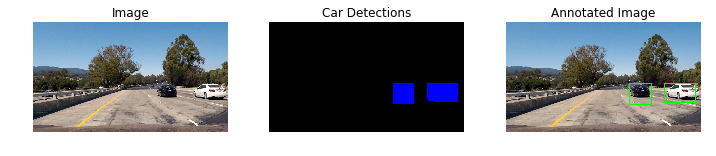

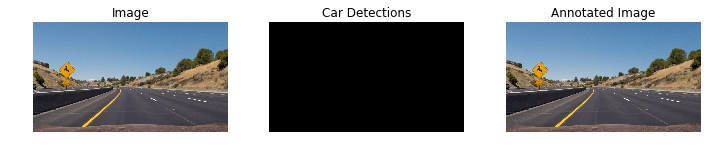

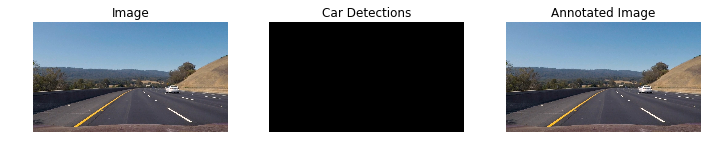

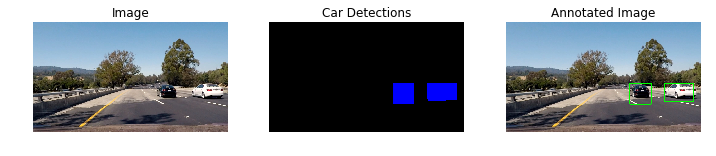

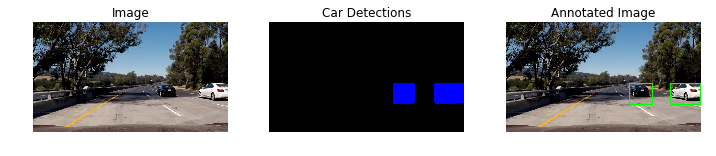

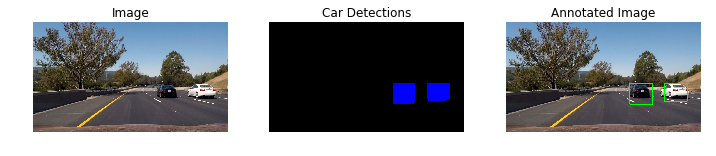

In [40]:
for image in glob.glob('test_images/*.jpg'):
    image = imread(image)
    pipeline(image, clf='MLP', vis=True, feat_type='hog + color histograms')

In [45]:
clip_raw = VideoFileClip('project_video.mp4')
clip_processed = clip_raw.fl_image(pipeline)
clip_processed.write_videofile('result.mp4', audio=False)
HTML("""
<video width="640" height="360" controls>
  <source src="result.mp4">
</video>
""")

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [09:39<00:00,  2.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

